# Apr 07, 2022 (Fig 4, OCs, cosine sim, DMN)

**Motivation**: This also has DMN rendering function. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

## OCs + disjoint

In [5]:
proj_ca = gr_ca.project_vec()
proj_bold = gr_bold.project_vec()

tr_ca = gr_bold.trim2d(proj_ca)
tr_bold = gr_bold.trim2d(proj_bold)

In [6]:
save_dir = pjoin(fig_dir, 'Fig4')
os.makedirs(save_dir, exist_ok=True)

In [7]:
min_thres = 0.15
vmin = 0.15
vmax = 0.8
cm = 'magma'

In [8]:
set_style()

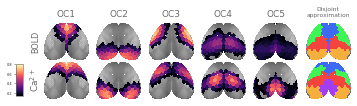

In [9]:
fig = plt.figure(figsize=(6., 1.4), tight_layout=False, constrained_layout=False)
gs = GridSpec(6, 8, height_ratios=[0., 3, 0.1] * 2, width_ratios=[0.15, 0.15] + [1] * 6)

for i in range(2, 5 + 3):
    ax = fig.add_subplot(gs[:3, i])
    x2p = np.ma.masked_where(tr_bold['top'] == 0, tr_bold['top'])
    ax.imshow(x2p, cmap='Greys_r')

    x2p = tr_bold['proj-top'][i - 2]
    if i == 7:
        x2p = np.ma.masked_where(x2p == 0, x2p)
        ax.imshow(x2p, cmap=gr_bold.cmaps[-1])
        ax.set_title(f'Disjoint\napproximation', fontsize=6, color='dimgrey')
    else:
        x2p = np.ma.masked_where(x2p < min_thres, x2p)
        ax.imshow(x2p, cmap=cm, vmin=vmin, vmax=vmax)
        ax.set_title(f'OC{i - 1}', fontsize=9, color='dimgrey')
    if i == 2:
        ax.set_ylabel(r'BOLD', fontsize=8, color='dimgrey')
    remove_ticks(ax)
        
    ax = fig.add_subplot(gs[3:, i])
    x2p = np.ma.masked_where(tr_ca['top'] == 0, tr_ca['top'])
    ax.imshow(x2p, cmap='Greys_r')

    x2p = tr_ca['proj-top'][i - 2]
    if i == 7:
        x2p = np.ma.masked_where(x2p == 0, x2p)
        ax.imshow(x2p, cmap=gr_ca.cmaps[-1])
    else:
        x2p = np.ma.masked_where(x2p < min_thres, x2p)
        im = ax.imshow(x2p, cmap=cm, vmin=vmin, vmax=vmax, interpolation='none')
    if i == 2:
        ax.set_ylabel(r'Ca$^{2+}$', fontsize=9, labelpad=2.5, color='dimgrey')
    remove_ticks(ax)

cax = fig.add_subplot(gs[4, 0])
cbar = plt.colorbar(im, cax=cax)
cax.yaxis.set_ticks_position('left')
cax.tick_params(axis='y', labelsize=3.5, width=0.6, length=2, pad=1, color='dimgrey')
cbar.outline.set_edgecolor('dimgrey')
cbar.outline.set_linewidth(0.6)

name = f'OCs'
for ext in ['pdf']:
    figname = f"{name}.{ext}"
    fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

## Cosine

In [10]:
%%time

ci, dof = 0.95, 9
whis = np.round((1 + ci) / 2, 5)
tval = sp_stats.t.ppf(whis, dof)

dims = {'sub': 10, 'ses': 3, 'run': 4}
dlist, cos_sim = [], {}
for k in range(3, 7):
    _props_b = props_bold.copy()
    _props_c = props_ca.copy()
    _props_b['num_k'] = k
    _props_c['num_k'] = k

    _gr_c = Group(**_props_c).fit_group()
    _gr_b = Group(**_props_b).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_b.grp_pi,
        XB=_gr_c.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())
    
    sim = dist2sim(sp_dist.cdist(
        XA=_gr_b.grp_pi_prune,
        XB=_gr_c.grp_pi_prune[ids],
        metric='cosine',
    ))
    cos_sim[k] = sim
    sim = sim.diagonal()
    scores = {i + 1: s for i, s in enumerate(sim)}
    scores = {**scores, 100: sim.mean()}

    x = np.concatenate([
        np.expand_dims(_gr_b.run_pi_prune, -1),
        np.expand_dims(_gr_c.run_pi_prune[..., ids, :], -1),
    ], axis=-1)
    boot = bootstrap(
        x=x,
        batch=5,
        dims=dims,
        n_resamples=int(1e4),
    )
    boot = bn.nanmean(bn.nanmean(bn.nanmean(boot, 3), 2), 1)
    sim = []
    for b in range(len(boot)):
        if np.isnan(boot[b]).sum():
            continue
        sim.append(np.expand_dims(dist2sim(sp_dist.cdist(
            XA=boot[b, ..., 0],
            XB=boot[b, ..., 1],
            metric='cosine',
        )), axis=0))
    sim = np.concatenate(sim)
    sim = sim.diagonal(0, 1, 2)

    # Local (for each OC separately)
    se = np.nanstd(sim, axis=0, ddof=1)
    error = list(se * tval)

    # Global (average over all OCs)
    se = np.nanstd(sim.mean(-1), ddof=1)
    error.append(se * tval)
    
    dlist.append({
        'k': [k] * len(scores),
        'oc_idx': scores.keys(),
        'value': scores.values(),
        'hi': [s + e for s, e in zip(scores.values(), error)],
        'lo': [s - e for s, e in zip(scores.values(), error)],
        'error': error,
    })
    
df = pd.DataFrame(merge_dicts(dlist))

CPU times: user 38.5 s, sys: 55.5 s, total: 1min 33s
Wall time: 1min 34s


In [11]:
set_style()

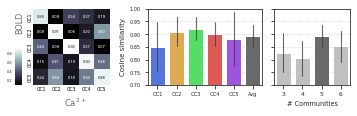

In [12]:
fig = plt.figure(figsize=(6, 1.4), tight_layout=False, constrained_layout=False)
gs = GridSpec(2, 5, width_ratios=[0.085, 1, 0.2, 1.5, 1], height_ratios=[1, 1.2])

cax = fig.add_subplot(gs[1, 0])
ax = fig.add_subplot(gs[:, 1])
x = sns.heatmap(
    cos_sim[5], 
    vmin=0.1,
    vmax=0.93,
    cbar=True,
    cmap='bone',
    annot=True,
    square=True,
    fmt='.2f',
    linewidths=0.,
    annot_kws={
        'fontsize': 4.,
        'fontname': 'Loma'},
    cbar_kws={},
    cbar_ax=cax,
    ax=ax,
)
ax.set_ylabel('BOLD', fontsize=8, labelpad=3, y=0.82, color='dimgrey')
ax.set_xlabel(r'Ca$^{2+}$', fontsize=8.5, labelpad=5, x=0.55, color='dimgrey')
ax.set_xticklabels([f"OC{k}" for k in range(1, 6)], color='k')
ax.set_yticklabels([f"OC{k}" for k in range(1, 6)], color='k')
ax.tick_params(axis='both', labelsize=4.5, length=0, pad=1)
ax.tick_params(axis='x', pad=1.5)
cax.yaxis.set_ticks_position('left')
cax.tick_params(axis='y', labelsize=3.5, width=0.3, length=1.5, pad=1, color='dimgrey')
cbar.outline.set_edgecolor('dimgrey')
cbar.outline.set_linewidth(0.6)

ax = fig.add_subplot(gs[:, 3])
_df = df.loc[(df['k'] == 5)]
_, palette = get_cluster_cmap(range(5), return_colors=True)
palette = {i + 1: c for i, c in enumerate(palette)}
palette[100] = 'dimgrey'

sns.barplot(
    data=_df,
    x='oc_idx',
    y='value',
    palette=palette,
    ci='sd',
    ax=ax,
)
lines = ax.get_lines()
for i, oc_idx in enumerate(_df['oc_idx'].unique()):
    lo, hi = _df.loc[_df['oc_idx'] == oc_idx, ['lo', 'hi']].values.ravel()
    lines[i].set_ydata([lo, hi])
    lines[i].set_lw(1.1)
    lines[i].set_alpha(0.8)
ax.set_xlabel('')
ax.set_ylabel('Cosine similarity', fontsize=7)
ax.set_xticklabels([f"OC{i}" for i in range(1, 5 + 1)] + ['Avg'])
ax.tick_params(axis='both', labelsize=5)
ax.set_ylim(0.7, 1.0)
ax.grid(axis='y')


ax = fig.add_subplot(gs[:, 4])
_df = df.loc[df['oc_idx'] == 100]
palette = {i: 'silver' for i in _df['k'].unique()}
palette[5] = 'dimgrey'

sns.barplot(
    data=_df,
    x='k',
    y='value',
    palette=palette,
    ci='sd',
    ax=ax,
)
lines = ax.get_lines()
for i, k in enumerate(_df['k'].unique()):
    lo, hi = _df.loc[_df['k'] == k, ['lo', 'hi']].values.ravel()
    lines[i].set_ydata([lo, hi])
    lines[i].set_lw(1.1)
    lines[i].set_alpha(0.8)

# axes[1].set_xlabel('')
ax.set_ylabel('')
ax.set_xlabel('# Communities', fontsize=6.5)
ax.tick_params(axis='both', labelsize=5)
ax.tick_params(axis='x', labelsize=6)
ax.set_yticklabels([])
ax.set_ylim(0.7, 1.0)
ax.grid(axis='y')



name = f'COS'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{int(dpi / 100)}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)
plt.show()

### Calculate sim before avging?

In [298]:
k = 5

_props_b = props_bold.copy()
_props_c = props_ca.copy()
_props_b['num_k'] = k
_props_c['num_k'] = k

_gr_c = Group(**_props_c).fit_group()
_gr_b = Group(**_props_b).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=_gr_b.grp_pi,
    XB=_gr_c.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())
ids

[0, 1, 2, 3, 4]

In [299]:
run_sim = np.zeros((10, 3, 4, 5, 5))
looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    good_nodes = np.where(np.logical_or(
        np.isnan(_gr_b.run_pi[i, j, k]),
        np.isnan(_gr_c.run_pi[i, j, k]),
    ).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    run_sim[i, j, k] = dist2sim(sp_dist.cdist(
        XA=_gr_b.run_pi[i, j, k][:, good_nodes],
        XB=_gr_c.run_pi[i, j, k][:, good_nodes],
        metric='cosine',
    ))
run_sim.shape

(10, 3, 4, 5, 5)

In [300]:
a = bn.nanmean(bn.nanmean(bn.nanmean(run_sim, 2), 1), 0)
np.round(a.diagonal(), 2)

array([0.62, 0.63, 0.62, 0.55, 0.47])

In [301]:
np.round(cos_sim[5].diagonal(), 2)

array([0.85, 0.91, 0.92, 0.9 , 0.88])

In [304]:
anim_sim = np.zeros((10, 5, 5))
for i in range(10):
    good_nodes = np.where(np.logical_or(
        np.isnan(_gr_b.anim_pi_prune[i]),
        np.isnan(_gr_c.anim_pi_prune[i]),
    ).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    anim_sim[i] = dist2sim(sp_dist.cdist(
        XA=_gr_b.anim_pi_prune[i][:, good_nodes],
        XB=_gr_c.anim_pi_prune[i][:, good_nodes],
        metric='cosine',
    ))
anim_sim.shape

(10, 5, 5)

In [306]:
a = bn.nanmean(anim_sim, 0)
np.round(a.diagonal(), 2)

array([0.71, 0.78, 0.76, 0.67, 0.53])

In [307]:
anim_sim = np.zeros((10, 5, 5))
for i in range(10):
    good_nodes = np.where(np.logical_or(
        np.isnan(_gr_b.anim_pi[i]),
        np.isnan(_gr_c.anim_pi[i]),
    ).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    anim_sim[i] = dist2sim(sp_dist.cdist(
        XA=_gr_b.anim_pi[i][:, good_nodes],
        XB=_gr_c.anim_pi[i][:, good_nodes],
        metric='cosine',
    ))
anim_sim.shape

(10, 5, 5)

In [308]:
a = bn.nanmean(anim_sim, 0)
np.round(a.diagonal(), 2)

array([0.85, 0.88, 0.88, 0.86, 0.79])

## DMN compare

In [13]:
pth = '/home/hadi/Documents/MouseDMN'
file = pjoin(pth, 'ica_all_05_icasso_iter_1000_comp_0_mask_z_1_allen_masked_sym_thresh.nii.gz')
img = ants.image_read(file)

dmn = img.numpy()
dmn = np.transpose(dmn, (2, 1, 0))
dmn = dmn[::-1][:, ::-1, :]

In [14]:
cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)
regions_depth1 = regions[hcl[:, 2] == 0]

base = Base(mice, mode='ca2', prep_data=False)

len(regions), len(regions_depth1)

(768, 256)

In [15]:
regions_included = [
    int(lbl.split('-')[1])
    for lbl in base.l2n
]
regions_included = [
    mice.parcel.encode(f"1-{c}-0") for
    c in sorted(set(regions_included))
]
regions_included = mice.parcel.complement(regions_included)
len(regions_included)

164

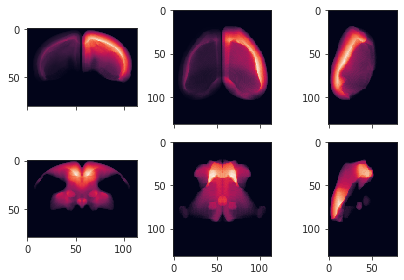

In [16]:
fig, axes = create_figure(2, 3, (6, 4), 'col', 'col')

for i in range(3):
    axes[0, i].imshow(cortex.mean(i))
    axes[1, i].imshow(dmn.mean(i))

In [17]:
mask_optical = np.isin(mice.parcel['cortex'], regions_included)
dmn_masked = dmn * mask_optical

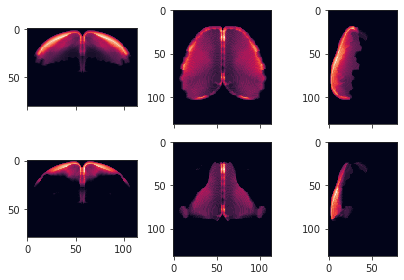

In [18]:
fig, axes = create_figure(2, 3, (6, 4), 'col', 'col')

for i in range(3):
    axes[0, i].imshow(mask_optical.mean(i))
    axes[1, i].imshow((dmn * mask_optical).mean(i))

### Render

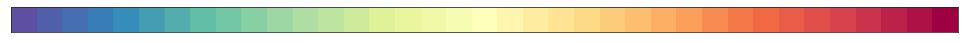

In [19]:
sys.path.insert(0, pjoin(git_dir, 'vedo'))
sys.path.insert(0, pjoin(git_dir, 'brainrender'))

from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume
from register.atlas import load_bg_atlas

cmap = sns.color_palette('Spectral_r', as_cmap=True)
display_cmap(cmap)

In [27]:
f = 'parcel2d-flat_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_flat = ants.image_read(f, pixeltype='unsigned int')
parcel_flat = parcel_flat.numpy()

f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parcel_top = ants.image_read(f, pixeltype='unsigned int')
parcel_top = parcel_top.numpy()

In [ ]:
for i in regions_included:
    x2p = mwh(parcel_flat == 0, parcel_flat == i)
    plt.imshow(x2p)
    plt.title(i)
    plt.show()

In [33]:
regions_included_final = [
    i for i in regions_included if i not
    in mice.parcel.complement([10, 15])
]

In [34]:
mask_depth1 = np.isin(cortex, regions_depth1)
mask_included = np.isin(cortex, regions_included_final)
mask_removed = np.logical_and(mask_depth1, ~mask_included)

dmn_optical = dmn * mask_included.astype(bool)
dmn_complement = np.logical_and(dmn, ~dmn_optical.astype(bool))

In [35]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [36]:
alpha = 1.0
surfaces, names, colors = [], [], []

c = 'goldenrod'
colors.append(c)
x = src_space.map_stack_to(scene.atlas.space, dmn_optical)
vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append('dmn_optical')


c = 'dimgrey'
colors.append(c)
x = src_space.map_stack_to(scene.atlas.space, dmn_complement)
vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append('dmn_complement')


scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)


save_name = 'DMN-optical'
html_file = pjoin(save_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper/Fig4/DMN-optical.html

### Pi DMN = 1 + 4 + 5

In [37]:
dmn_oc_idxs = [0, 3, 4]
pi_dmn_ca = gr_ca.pi[dmn_oc_idxs].sum(0)
pi_dmn_bold = gr_bold.pi[dmn_oc_idxs].sum(0)

tr_dmn_ca = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr_dmn_bold = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)

tr_dmn_ca = gr_ca.trim2d(tr_dmn_ca)
tr_dmn_bold = gr_ca.trim2d(tr_dmn_bold)

<matplotlib.colorbar.Colorbar object at 0x7f5b8e895f40>

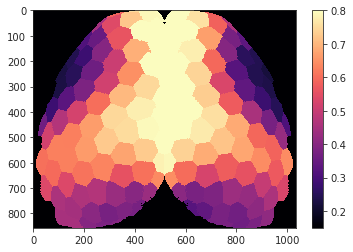

In [38]:
plt.imshow(tr_dmn_bold['proj-top'][0], cmap='magma', vmin=0.15, vmax=0.8)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f5b8e0b1d90>

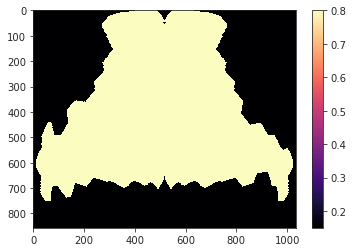

In [39]:
plt.imshow(tr_dmn_bold['proj-top'][0] > 0.50, cmap='magma', vmin=0.15, vmax=0.8)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f5b8e40bdf0>

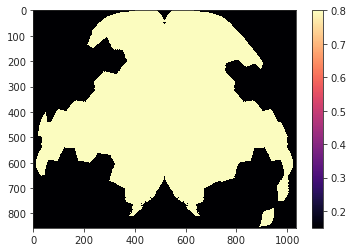

In [40]:
plt.imshow(tr_dmn_ca['proj-top'][0] > 0.50, cmap='magma', vmin=0.15, vmax=0.8)
plt.colorbar()

In [41]:
scores_dmn = {}
for i in regions_included:
    scores_dmn[i] = overlap_score(cortex == i, dmn_optical.astype(bool))

scores_vec = np.zeros(len(gr_ca.n2l))
for r, sc in scores_dmn.items():
    hh, cc, ll = mice.parcel.decode(r).ravel()
    lbl = f"{hh}-{cc}-{ll}"
    node = gr_ca.l2n[lbl]
    scores_vec[node] = sc

In [42]:
tr_dmn = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr_dmn = gr_ca.trim2d(tr_dmn)

<matplotlib.colorbar.Colorbar object at 0x7f5b94371940>

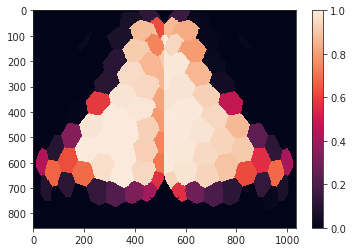

In [43]:
plt.imshow(tr_dmn['proj-top'][0], vmin=0, vmax=1)
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7f5b8e8835e0>

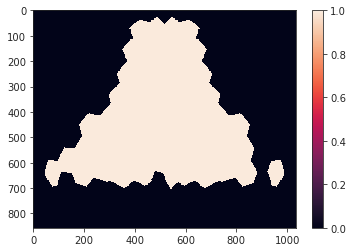

In [44]:
plt.imshow(tr_dmn['proj-top'][0] > 0.6)
plt.colorbar()

In [535]:
n = 100
xs_dmn = np.linspace(0, 0.6, n)
xs = np.linspace(0.4, 0.7, n // 2)

scores_ca = np.zeros((n, n // 2))
scores_bold = np.zeros((n, n // 2))
for i, th_dmn in tqdm(enumerate(xs_dmn), total=n):
    x_dmn = dc(tr_dmn['proj-top'][0])
    x_dmn[x_dmn <= th_dmn] = 0
    x_dmn[x_dmn > th_dmn] = 1
    for j, th in enumerate(xs):
        x_bold = dc(tr_dmn_bold['proj-top'][0])
        x_bold[x_bold <= th] = 0
        x_bold[x_bold > th] = 1
        scores_bold[i, j] = dice_score(x_dmn.astype(bool), x_bold.astype(bool))
        
        x_ca = dc(tr_dmn_ca['proj-top'][0])
        x_ca[x_ca <= th] = 0
        x_ca[x_ca > th] = 1
        scores_ca[i, j] =dice_score(x_dmn.astype(bool), x_ca.astype(bool))

scores_ca[np.isnan(scores_ca)] = 0
scores_bold[np.isnan(scores_bold)] = 0

  0%|          | 0/100 [00:00<?, ?it/s]

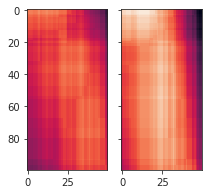

In [562]:
fig, axes = create_figure(1, 2, (3, 3), 'all', 'all')

vmin = min(scores_ca.min(), scores_bold.min())
vmax = max(scores_ca.max(), scores_bold.max())

axes[0].imshow(scores_ca, vmin=vmin, vmax=vmax)
axes[1].imshow(scores_bold, vmin=vmin, vmax=vmax)

plt.show()

Text(0.5, 1.0, 'th bold')

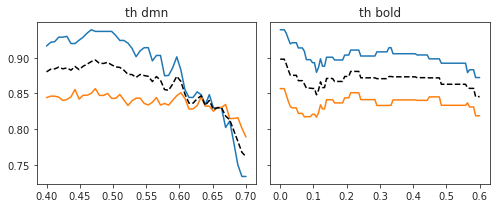

In [563]:
fig, axes = create_figure(1, 2, (7, 3), sharey='all')

a = (np.max(scores_bold, axis=0) + np.max(scores_ca, axis=0)) / 2
axes[0].plot(xs, np.max(scores_bold, axis=0))
axes[0].plot(xs, np.max(scores_ca, axis=0))
axes[0].plot(xs, a, 'k--')
axes[0].set_title('th dmn')

b = (np.max(scores_bold, axis=1) + np.max(scores_ca, axis=1)) / 2
axes[1].plot(xs_dmn, np.max(scores_bold, axis=1))
axes[1].plot(xs_dmn, np.max(scores_ca, axis=1))
axes[1].plot(xs_dmn, b, 'k--')
axes[1].set_title('th bold')

In [564]:
best_i, best_j = np.argmax(a), np.argmax(b)
best_i, best_j

(12, 0)

In [565]:
th_best = {
    'dmn': xs[best_i],
    'ca2': xs[np.argmax(scores_ca[best_i])],
    'bold': xs[np.argmax(scores_bold[best_i])],
}
th_best

{
    'dmn': 0.47346938775510206,
    'ca2': 0.4428571428571429,
    'bold': 0.4673469387755102
}

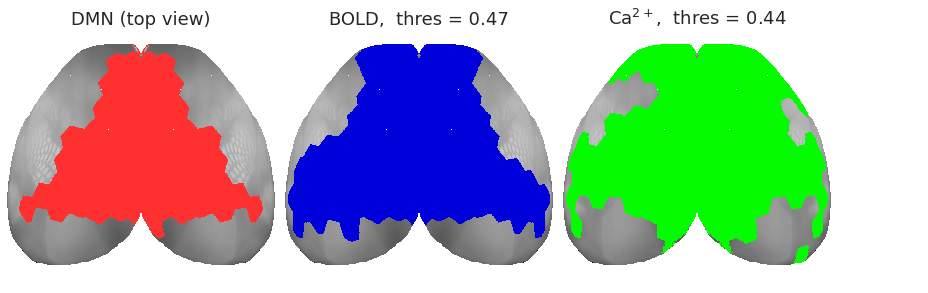

In [566]:
fig, axes = create_figure(1, 4, (13, 4), width_ratios=[1] * 3 + [0.3])

for ax in axes.flat[:3]:
    x2p = mwh(tr_dmn['top'] == 0, tr_dmn['top'])
    ax.imshow(x2p, cmap='Greys_r')

x2p = dc(tr_dmn['proj-top'][0])
x2p[x2p <= th_best['dmn']] = 0
x2p[x2p > th_best['dmn']] = 0.7
x2p = mwh(x2p == 0, x2p)
axes[0].imshow(x2p, cmap='seismic', vmin=0, vmax=1.)

x2p = dc(tr_dmn_bold['proj-top'][0])
x2p[x2p <= th_best['bold']] = 0
x2p[x2p > th_best['bold']] = 0.20
x2p = mwh(x2p == 0, x2p)
axes[1].imshow(x2p, cmap='seismic', vmin=0, vmax=1.)


x2p = dc(tr_dmn_ca['proj-top'][0])
x2p[x2p <= th_best['ca2']] = 0
x2p[x2p > th_best['ca2']] = 0.99
x2p = mwh(x2p == 0, x2p)
axes[2].imshow(x2p, cmap='brg', vmin=0, vmax=1.)

axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
axes[1].set_title(f"BOLD,  thres = {th_best['bold']:0.2f}", fontsize=18, y=1.06)
axes[2].set_title(r'Ca$^{2+}$' + f",  thres = {th_best['ca2']:0.2f}", fontsize=18, y=1.06)

remove_ticks(axes)

name = f'DMN-compare'
figname = f"{name}.pdf"
# fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    # fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

plt.show()

[<matplotlib.lines.Line2D object at 0x7f5b8e84ee20>]

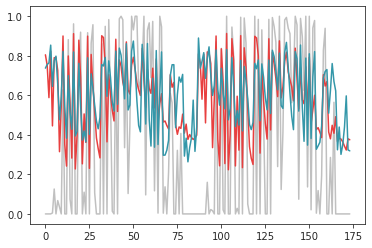

In [48]:
plt.plot(scores_vec, color='silver')
plt.plot(pi_dmn_bold, color=pal['bold-lite'])
plt.plot(pi_dmn_ca, color=pal['ca2'])

In [49]:
n = 200
xs_dmn = np.linspace(0.2, 0.7, n)
xs = np.linspace(0.2, 0.6, n // 2)

scores_ca = np.zeros((n, n // 2))
scores_bold = np.zeros((n, n // 2))
for i, th_dmn in tqdm(enumerate(xs_dmn), total=n):
    x_dmn = dc(scores_vec)
    x_dmn[x_dmn <= th_dmn] = 0
    x_dmn[x_dmn > th_dmn] = 1
    for j, th in enumerate(xs):
        x_bold = dc(pi_dmn_bold)
        x_bold[x_bold <= th] = 0
        x_bold[x_bold > th] = 1
        scores_bold[i, j] = 1 - sp_dist.hamming(x_dmn.astype(bool), x_bold.astype(bool))
        
        x_ca = dc(pi_dmn_ca)
        x_ca[x_ca <= th] = 0
        x_ca[x_ca > th] = 1
        scores_ca[i, j] = 1 - sp_dist.hamming(x_dmn.astype(bool), x_ca.astype(bool))

scores_ca[np.isnan(scores_ca)] = 0
scores_bold[np.isnan(scores_bold)] = 0

  0%|          | 0/200 [00:00<?, ?it/s]

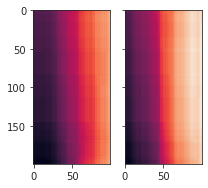

In [50]:
fig, axes = create_figure(1, 2, (3, 3), 'all', 'all')

vmin = min(scores_ca.min(), scores_bold.min())
vmax = max(scores_ca.max(), scores_bold.max())

axes[0].imshow(scores_ca, vmin=vmin, vmax=vmax)
axes[1].imshow(scores_bold, vmin=vmin, vmax=vmax)

plt.show()

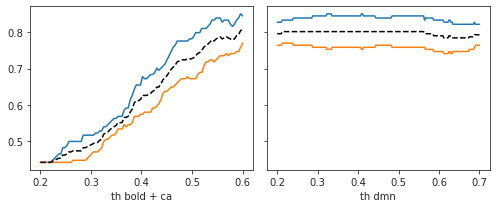

In [51]:
fig, axes = create_figure(1, 2, (7, 3), sharey='all')

a = (np.max(scores_bold, axis=0) + np.max(scores_ca, axis=0)) / 2
axes[0].plot(xs, np.max(scores_bold, axis=0))
axes[0].plot(xs, np.max(scores_ca, axis=0))
axes[0].plot(xs, a, 'k--')
axes[0].set_xlabel('th bold + ca')

b = (np.max(scores_bold, axis=1) + np.max(scores_ca, axis=1)) / 2
axes[1].plot(xs_dmn, np.max(scores_bold, axis=1))
axes[1].plot(xs_dmn, np.max(scores_ca, axis=1))
axes[1].plot(xs_dmn, b, 'k--')
axes[1].set_xlabel('th dmn')
plt.show()

In [52]:
best_i, best_j = np.argmax(a), np.argmax(b)
best_i, best_j

(99, 5)

In [53]:
th_best = {
    'dmn': xs_dmn[best_j],
    'ca2': xs[np.argmax(scores_ca[best_j])],
    'bold': xs[np.argmax(scores_bold[best_j])],
}
th_best

{'dmn': 0.21256281407035177, 'ca2': 0.6, 'bold': 0.5474747474747474}

In [54]:
# th_best['bold'] = 0.55
th_best['ca2'] = 0.525
th_best

{'dmn': 0.21256281407035177, 'ca2': 0.525, 'bold': 0.5474747474747474}

In [55]:
save_dir = pjoin(fig_dir, 'Fig4')

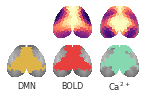

In [59]:
fig, axes = create_figure(2, 3, (2.35, 1.3), tight_layout=False, constrained_layout=False)

axes[0, 0].remove()
for ax in axes.flat:
    x2p = mwh(tr_dmn['top'] == 0, tr_dmn['top'])
    ax.imshow(x2p, cmap='Greys_r')
x2p = tr_dmn_bold['proj-top'][0]
x2p = mwh(x2p < 0.15, x2p)
axes[0, 1].imshow(x2p, cmap='magma', vmin=0.15, vmax=0.80)
x2p = tr_dmn_ca['proj-top'][0]
x2p = mwh(x2p < 0.15, x2p)
axes[0, 2].imshow(x2p, cmap='magma', vmin=0.15, vmax=0.80)

x2p = dc(tr_dmn['proj-top'][0])
x2p[x2p <= th_best['dmn']] = 0
x2p[x2p > th_best['dmn']] = 0.8
x2p = mwh(x2p == 0, x2p)
axes[1, 0].imshow(x2p, cmap=sns.light_palette('goldenrod', as_cmap=True), vmin=0, vmax=1.)

x2p = dc(tr_dmn_bold['proj-top'][0])
x2p[x2p <= th_best['bold']] = 0
x2p[x2p > th_best['bold']] = 1
x2p = mwh(x2p == 0, x2p)
axes[1, 1].imshow(x2p, cmap=sns.light_palette(pal['bold-lite'], as_cmap=True), vmin=0, vmax=1.)


x2p = dc(tr_dmn_ca['proj-top'][0])
x2p[x2p <= th_best['ca2']] = 0
x2p[x2p > th_best['ca2']] = 0.85
x2p = mwh(x2p == 0, x2p)
axes[1, 2].imshow(x2p, cmap='mako', vmin=0, vmax=1.)

# axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
# axes[1].set_title(f"BOLD,  thres = {th_best['bold']:0.2f}", fontsize=18, y=1.06)
# axes[2].set_title(r'Ca$^{2+}$' + f",  thres = {th_best['ca2']:0.2f}", fontsize=18, y=1.06)

axes[1, 0].set_xlabel('DMN', fontsize=8)
axes[1, 1].set_xlabel('BOLD', fontsize=8)
axes[1, 2].set_xlabel(r'Ca$^{2+}$', fontsize=8.5, labelpad=2.5)

remove_ticks(axes)

name = f'DMN-compare'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)
for dpi in [600, 1000]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(save_dir, figname), dpi=dpi, **fig_kws)

plt.show()

## Finally, add num k detection from SVINET

In [218]:
this = '/home/hadi/Documents/workspaces/svinet/n-192*4_ca2_rest_pearson_sub-SLC10_ses-1_run-5/real'